## Read Sentinel-2 files from public bucket

Set the env variables to be able to read from the Google bucket. This is needed to cover reading costs

In [1]:
import os
# Donwload key from next line link to access the buckets and requester pays requests to public bucket (this is needed to query Sentinel-2 data)
# https://console.cloud.google.com/iam-admin/serviceaccounts/details/113408056464434182094/keys?authuser=1&project=cs-starcop-dtacs&supportedpurview=project
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/cs-starcop-dtacs-620b59dd7276.json"
os.environ["GS_USER_PROJECT"] = "cs-starcop-dtacs"

In [2]:
%%time
from georeader.readers import S2_SAFE_reader

safe_file = "S2B_MSIL1C_20220527T030539_N0400_R075_T49SGV_20220527T051042.SAFE"
s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(safe_file, check_exists=True)

print(f"File is located at: {s2_safe_folder}")

s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10)
s2obj

File is located at: gs://gcp-public-data-sentinel-2/tiles/49/S/GV/S2B_MSIL1C_20220527T030539_N0400_R075_T49SGV_20220527T051042.SAFE
CPU times: user 770 ms, sys: 430 ms, total: 1.2 s
Wall time: 967 ms


 
         gs://gcp-public-data-sentinel-2/tiles/49/S/GV/S2B_MSIL1C_20220527T030539_N0400_R075_T49SGV_20220527T051042.SAFE
         Transform: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (699960.0, 3890220.0, 809760.0, 4000020.0)
         CRS: EPSG:32649
         bands: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
         fill_value_default: 0
        

Select the bands and bounds to read and trigger `load` (to read the data in memory)

In [3]:
%%time
from georeader import read
bounds_read = (759760.0, 3940220.0, 799760.0, 3960220.0)

s2obj.bands = ["B04", "B03", "B02"]
data = read.read_from_bounds(s2obj, bounds_read) # This does not trigger the download of the data
data_memory = data.load() # this triggers download only for the selected bands and within the bounds
data_memory

CPU times: user 14.6 s, sys: 1.79 s, total: 16.4 s
Wall time: 39.3 s


 
         Transform: | 10.00, 0.00, 759760.00|
| 0.00,-10.00, 3960220.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 2000, 4000)
         Resolution: (10.0, 10.0)
         Bounds: (759760.0, 3940220.0, 799760.0, 3960220.0)
         CRS: EPSG:32649
         fill_value_default: 0
        

The `numpy.array` is stored in the `values` property.

In [4]:
%%time
data_memory.values

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


array([[[1314, 1139, 1156, ..., 1517, 1730, 1561],
        [1309, 1142, 1274, ..., 1581, 1730, 1508],
        [1335, 1288, 1526, ..., 1659, 1688, 1395],
        ...,
        [1510, 1539, 1567, ..., 1012, 1016, 1028],
        [1479, 1514, 1545, ...,  974,  952,  954],
        [1517, 1515, 1555, ...,  951,  952,  946]],

       [[1395, 1271, 1275, ..., 1460, 1567, 1423],
        [1355, 1260, 1347, ..., 1450, 1584, 1385],
        [1396, 1360, 1502, ..., 1483, 1569, 1326],
        ...,
        [1570, 1585, 1595, ..., 1159, 1160, 1147],
        [1563, 1572, 1578, ..., 1151, 1133, 1105],
        [1555, 1576, 1562, ..., 1147, 1135, 1112]],

       [[1398, 1301, 1320, ..., 1560, 1629, 1459],
        [1386, 1319, 1403, ..., 1608, 1605, 1418],
        [1417, 1401, 1544, ..., 1633, 1561, 1377],
        ...,
        [1690, 1699, 1687, ..., 1216, 1218, 1215],
        [1665, 1670, 1666, ..., 1213, 1208, 1195],
        [1653, 1647, 1652, ..., 1204, 1208, 1191]]], dtype=uint16)

Plot the data that we have read

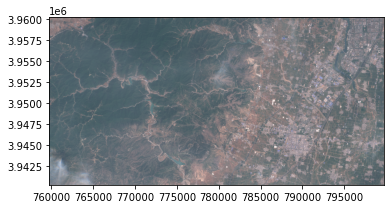

CPU times: user 1.83 s, sys: 2.42 s, total: 4.24 s
Wall time: 4.09 s


<AxesSubplot:>

In [5]:
%%time

import rasterio.plot as rstplt
import numpy as np

# From processing baseline PB04.00  values have an offset of 1_000
rstplt.show(np.clip(data_memory.values/3_000,0,1), transform=data_memory.transform)

## Read from JPEG 2000 pyramids

Instead of reading at the highest possible resolution (10m in Sentinel-2) we can take advantage of the jp2 format of Sentinel-2 files and read the a footprint which might be much faster. See `Wall time` in the output cell bellow.

In [6]:
%%time

from georeader import rasterio_reader
from georeader.geotensor import GeoTensor

bands_reader = data.get_reader(["B04", "B03", "B02"])
data_memory = rasterio_reader.read_out_shape(bands_reader, size_read=600)
data_memory

ERROR 1: Stream too short

ERROR 1: opj_get_decoded_tile() failed


CPU times: user 12.5 s, sys: 1.65 s, total: 14.2 s
Wall time: 35.8 s


 
         Transform: | 66.67, 0.00, 759760.00|
| 0.00,-66.67, 3960220.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 300, 600)
         Resolution: (66.66666666662786, 66.66666666651145)
         Bounds: (759760.0, 3940220.0, 799760.0, 3960220.0)
         CRS: EPSG:32649
         fill_value_default: 0
        

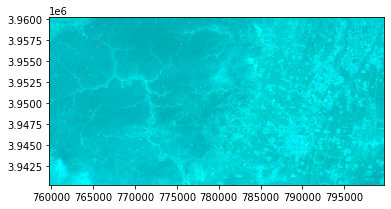

CPU times: user 313 ms, sys: 97.7 ms, total: 411 ms
Wall time: 201 ms


<AxesSubplot:>

In [7]:
%%time

rstplt.show(np.clip(data_memory.values/3_000,0,1), transform=data_memory.transform)

In [8]:
%%time

data_pyramid = data.get_reader(["B04", "B03", "B02"], overview_level=3)
data_pyramid_memory = data_pyramid.load()
data_pyramid_memory

CPU times: user 5.22 s, sys: 1.89 s, total: 7.11 s
Wall time: 34.3 s


 
         Transform: | 159.83, 0.00, 759734.67|
| 0.00,-159.83, 3960223.49|
| 0.00, 0.00, 1.00|
         Shape: (3, 126, 251)
         Resolution: (159.8253275109455, 159.8253275109455)
         Bounds: (759734.6724890829, 3940085.502183406, 799850.8296943231, 3960223.4934497816)
         CRS: EPSG:32649
         fill_value_default: 0
        

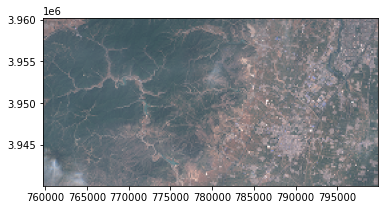

CPU times: user 302 ms, sys: 72.5 ms, total: 374 ms
Wall time: 162 ms


<AxesSubplot:>

In [10]:
%%time

rstplt.show(np.clip((data_pyramid_memory.values-1_000)/3_000,0,1), transform=data_pyramid_memory.transform)